In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib.animation
import yaml
import cv2
from scipy.spatial.transform import Rotation
from matplotlib.patches import Rectangle
from tqdm import tqdm
import argparse

sys.path.append('/home/schiavazza/code/hpe/hpe-core/datasets/')
sys.path.append('/local_code/hpe-core/datasets/')

from vicon_processing.src.projection import ProjectionHelper
from vicon_processing.src.data_helpers import DvsLabeler, DvsHelper, C3dHelper
from vicon_processing.src import vis_utils, utils

In [2]:
def obj_delay(delay):
    # import the DVS data
    dvs_file_path = "/home/schiavazza/data/hpe/vicon/side_f1_s/atis-s/"
    dvs_helper = DvsHelper(dvs_file_path)
    # read the labeled 2d points
    dvs_helper.read_points_labels("../scripts/config/side_s_labels.yml");
    # extract the time of the labeled points
    print(dvs_helper.labeled_points)
    labels_times = np.array(dvs_helper.labeled_points['times'])

    print(labels_times)
    # labels_times = [0.0]
    labels = list(dvs_helper.labeled_points['points'][0].keys())
    print(labels)


    # load c3d vicon data
    c3d_file_path = "/home/schiavazza/data/hpe/vicon/side_f1.c3d"
    c3d_helper = C3dHelper(c3d_file_path, delay=delay, camera_markers=False)
    print(c3d_helper.reader.point_labels)
    c3d_helper.reader.frame_count

    vicon_labeled_frames = c3d_helper.get_frame_time(labels_times)
    print(c3d_helper.frame_times)
    vicon_points = c3d_helper.get_vicon_points(vicon_labeled_frames, labels)
    vicon_points_mark = c3d_helper.transform_points_to_marker_frame(vicon_points)
    # vicon_points_mark = vicon_points
    print(vicon_labeled_frames)
    c3d_helper.markers_T
    print(f"times from dvs labels: {dvs_helper.labeled_points['times']}")
    print(f"times from vicon labels: {vicon_points_mark['times']}")
    dvs_helper.labeled_points['times']
    vicon_points_mark['times']
    proj_helper = ProjectionHelper(vicon_points_mark, dvs_helper.labeled_points)
    proj_helper.import_camera_calbration("../scripts/config/temp_calib.txt");
    proj_helper.image_points

    # find transform
    T, result = proj_helper._find_R_t(constrain_translation=False)
    print(result)

    return result.fun

In [3]:
delays = np.linspace(0.15, 0.3, 50)
res = []
for d in delays:
    r = obj_delay(d)
    r = r if r < 3000 else 3000
    res.append(r)
res = np.array(res)


no manual zero time found, using zero instead
{'points': [{'P3:HEDO': {'x': 778, 'y': 134}, 'P3:LFOO': {'x': 805, 'y': 618}, 'P3:RFOO': {'x': 701, 'y': 614}, 'P3:RHNO': {'x': 715, 'y': 353}}, {'P3:HEDO': {'x': 789, 'y': 152}, 'P3:LFOO': {'x': 836, 'y': 648}, 'P3:RFOO': {'x': 695, 'y': 638}, 'P3:RHNO': {'x': 682, 'y': 322}}, {'P3:HEDO': {'x': 798, 'y': 132}, 'P3:LFOO': {'x': 799, 'y': 649}, 'P3:RFOO': {'x': 693, 'y': 654}, 'P3:RHNO': {'x': 693, 'y': 395}}, {'P3:HEDO': {'x': 804, 'y': 144}, 'P3:LFOO': {'x': 797, 'y': 667}, 'P3:RFOO': {'x': 695, 'y': 654}, 'P3:RHNO': {'x': 692, 'y': 421}}, {'P3:HEDO': {'x': 809, 'y': 158}, 'P3:LFOO': {'x': 801, 'y': 651}, 'P3:RFOO': {'x': 603, 'y': 648}, 'P3:RHNO': {'x': 656, 'y': 393}}], 'times': [0.1, 0.375, 0.6499999999999999, 0.9249999999999999, 1.2]}
[0.1   0.375 0.65  0.925 1.2  ]
['P3:HEDO', 'P3:LFOO', 'P3:RFOO', 'P3:RHNO']
Selected the option to not use the markers on the camera, the identity transformation will be used instead
['camera:cam_right 

/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')
/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:270: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')
/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:270: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')


      fun: 5776.183433395946
 hess_inv: array([[2.45662647e-05, 2.80552101e-05, 1.85446034e-05, 1.20452998e-09,
        2.45494542e-09, 8.80230896e-09],
       [2.80552101e-05, 3.20396865e-05, 2.11785715e-05, 1.37555614e-09,
        2.80345375e-09, 1.00518983e-08],
       [1.85446042e-05, 2.11785725e-05, 2.36425227e-05, 1.36916097e-09,
        2.56395886e-09, 9.51436082e-09],
       [1.20454549e-09, 1.37557386e-09, 1.36917654e-09, 4.58753126e-11,
        9.06968933e-11, 3.48302492e-10],
       [2.45497476e-09, 2.80348725e-09, 2.56398834e-09, 9.06968942e-11,
        1.80361657e-10, 6.91889205e-10],
       [8.80242253e-09, 1.00520280e-08, 9.51447494e-09, 3.48302496e-10,
        6.91889205e-10, 2.65518534e-09]])
      jac: array([ 2.66312720e+03, -2.35304108e+03,  5.15471191e+01, -2.69437910e+04,
        1.39871213e+06, -3.50791733e+05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 607
      nit: 13
     njev: 85
   status: 2
  success: False
     

/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:270: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')
/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:270: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')


[26, 54, 81, 109, 136]
times from dvs labels: [0.1, 0.375, 0.6499999999999999, 0.9249999999999999, 1.2]
times from vicon labels: [0.10096837 0.38113212 0.65129001 0.93145375 1.20161165]
Number of 3d points: 20
Number of image points: 20
      fun: 5764.096099126967
 hess_inv: array([[ 3.44330890e-05,  3.93132363e-05,  2.44146684e-05,
        -2.12571356e-08, -4.51347657e-08, -1.69807123e-07],
       [ 3.93132363e-05,  4.48850639e-05,  2.78752985e-05,
        -2.42702537e-08, -5.15324303e-08, -1.93876574e-07],
       [ 2.44146753e-05,  2.78753064e-05,  2.75469682e-05,
        -1.81284382e-08, -3.86412865e-08, -1.45542556e-07],
       [-2.12571342e-08, -2.42702522e-08, -1.81284290e-08,
         2.32615407e-11,  4.82575175e-11,  1.80186045e-10],
       [-4.51347621e-08, -5.15324262e-08, -3.86412668e-08,
         4.82575166e-11,  1.00559705e-10,  3.75856936e-10],
       [-1.69807116e-07, -1.93876566e-07, -1.45542485e-07,
         1.80186050e-10,  3.75856954e-10,  1.40635028e-09]])
      ja

/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:270: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')


      fun: 5754.140331012288
 hess_inv: array([[ 2.78261516e-05,  3.17726972e-05,  2.16405203e-05,
        -1.09388139e-08, -2.19400147e-08, -8.31963286e-08],
       [ 3.17726972e-05,  3.62790011e-05,  2.47099714e-05,
        -1.24924317e-08, -2.50562157e-08, -9.50126455e-08],
       [ 2.16405203e-05,  2.47099714e-05,  2.72465449e-05,
         5.23244307e-09,  1.13819989e-08,  4.11191628e-08],
       [-1.09388032e-08, -1.24924195e-08,  5.23245537e-09,
         6.87853534e-10,  1.41246549e-09,  5.27280533e-09],
       [-2.19399931e-08, -2.50561910e-08,  1.13820238e-08,
         1.41246549e-09,  2.90104400e-09,  1.08286329e-08],
       [-8.31962471e-08, -9.50125524e-08,  4.11192568e-08,
         5.27280533e-09,  1.08286329e-08,  4.04228856e-08]])
      jac: array([ 2.71377307e+03, -2.34972449e+03,  5.46619873e+01, -1.38842087e+06,
        5.57603443e+05,  4.75011722e+04])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 635
      nit: 12
     njev: 89

/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:270: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')
/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:270: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')


      fun: 5754.140331012288
 hess_inv: array([[ 2.78261516e-05,  3.17726972e-05,  2.16405203e-05,
        -1.09388139e-08, -2.19400147e-08, -8.31963286e-08],
       [ 3.17726972e-05,  3.62790011e-05,  2.47099714e-05,
        -1.24924317e-08, -2.50562157e-08, -9.50126455e-08],
       [ 2.16405203e-05,  2.47099714e-05,  2.72465449e-05,
         5.23244307e-09,  1.13819989e-08,  4.11191628e-08],
       [-1.09388032e-08, -1.24924195e-08,  5.23245537e-09,
         6.87853534e-10,  1.41246549e-09,  5.27280533e-09],
       [-2.19399931e-08, -2.50561910e-08,  1.13820238e-08,
         1.41246549e-09,  2.90104400e-09,  1.08286329e-08],
       [-8.31962471e-08, -9.50125524e-08,  4.11192568e-08,
         5.27280533e-09,  1.08286329e-08,  4.04228856e-08]])
      jac: array([ 2.71377307e+03, -2.34972449e+03,  5.46619873e+01, -1.38842087e+06,
        5.57603443e+05,  4.75011722e+04])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 635
      nit: 12
     njev: 89

/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:270: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')
/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:270: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')


      fun: 5744.177498513189
 hess_inv: array([[ 2.26298103e-05,  2.58147646e-05,  9.03258828e-06,
         6.53193062e-09,  1.34661600e-08,  4.88229079e-08],
       [ 2.58147646e-05,  2.94479992e-05,  1.03051184e-05,
         7.44932307e-09,  1.53571508e-08,  5.56789547e-08],
       [ 9.03258694e-06,  1.03051168e-05,  2.71276632e-05,
        -3.22403699e-08, -7.19802984e-08, -2.60147906e-07],
       [ 6.53193272e-09,  7.44932547e-09, -3.22403688e-08,
         6.14885979e-11,  1.36388096e-10,  4.92731362e-10],
       [ 1.34661650e-08,  1.53571566e-08, -7.19802959e-08,
         1.36388096e-10,  3.03081202e-10,  1.09495217e-09],
       [ 4.88229262e-08,  5.56789756e-08, -2.60147897e-07,
         4.92731363e-10,  1.09495217e-09,  3.95638078e-09]])
      jac: array([ 2.66672095e+03, -2.35598340e+03,  3.52917480e+01,  1.30693022e+06,
       -8.01802431e+05,  8.93902217e+04])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 551
      nit: 15
     njev: 77

/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:270: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')


['camera:cam_right              ' 'camera:cam_back               '
 'camera:cam_left               ' 'P3:PELO                       '
 'P3:PELA                       ' 'P3:PELL                       '
 'P3:PELP                       ' 'P3:LFEO                       '
 'P3:LFEA                       ' 'P3:LFEL                       '
 'P3:LFEP                       ' 'P3:LTIO                       '
 'P3:LTIA                       ' 'P3:LTIL                       '
 'P3:LTIP                       ' 'P3:LFOO                       '
 'P3:LFOA                       ' 'P3:LFOL                       '
 'P3:LFOP                       ' 'P3:LTOO                       '
 'P3:LTOA                       ' 'P3:LTOL                       '
 'P3:LTOP                       ' 'P3:RFEO                       '
 'P3:RFEA                       ' 'P3:RFEL                       '
 'P3:RFEP                       ' 'P3:RTIO                       '
 'P3:RTIA                       ' 'P3:RTIL                    

/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:270: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')


['camera:cam_right              ' 'camera:cam_back               '
 'camera:cam_left               ' 'P3:PELO                       '
 'P3:PELA                       ' 'P3:PELL                       '
 'P3:PELP                       ' 'P3:LFEO                       '
 'P3:LFEA                       ' 'P3:LFEL                       '
 'P3:LFEP                       ' 'P3:LTIO                       '
 'P3:LTIA                       ' 'P3:LTIL                       '
 'P3:LTIP                       ' 'P3:LFOO                       '
 'P3:LFOA                       ' 'P3:LFOL                       '
 'P3:LFOP                       ' 'P3:LTOO                       '
 'P3:LTOA                       ' 'P3:LTOL                       '
 'P3:LTOP                       ' 'P3:RFEO                       '
 'P3:RFEA                       ' 'P3:RFEL                       '
 'P3:RFEP                       ' 'P3:RTIO                       '
 'P3:RTIA                       ' 'P3:RTIL                    

/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:270: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')
/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:270: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)


['camera:cam_right              ' 'camera:cam_back               '
 'camera:cam_left               ' 'P3:PELO                       '
 'P3:PELA                       ' 'P3:PELL                       '
 'P3:PELP                       ' 'P3:LFEO                       '
 'P3:LFEA                       ' 'P3:LFEL                       '
 'P3:LFEP                       ' 'P3:LTIO                       '
 'P3:LTIA                       ' 'P3:LTIL                       '
 'P3:LTIP                       ' 'P3:LFOO                       '
 'P3:LFOA                       ' 'P3:LFOL                       '
 'P3:LFOP                       ' 'P3:LTOO                       '
 'P3:LTOA                       ' 'P3:LTOL                       '
 'P3:LTOP                       ' 'P3:RFEO                       '
 'P3:RFEA                       ' 'P3:RFEL                       '
 'P3:RFEP                       ' 'P3:RTIO                       '
 'P3:RTIA                       ' 'P3:RTIL                    

/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')
/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:270: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)


['camera:cam_right              ' 'camera:cam_back               '
 'camera:cam_left               ' 'P3:PELO                       '
 'P3:PELA                       ' 'P3:PELL                       '
 'P3:PELP                       ' 'P3:LFEO                       '
 'P3:LFEA                       ' 'P3:LFEL                       '
 'P3:LFEP                       ' 'P3:LTIO                       '
 'P3:LTIA                       ' 'P3:LTIL                       '
 'P3:LTIP                       ' 'P3:LFOO                       '
 'P3:LFOA                       ' 'P3:LFOL                       '
 'P3:LFOP                       ' 'P3:LTOO                       '
 'P3:LTOA                       ' 'P3:LTOL                       '
 'P3:LTOP                       ' 'P3:RFEO                       '
 'P3:RFEA                       ' 'P3:RFEL                       '
 'P3:RFEP                       ' 'P3:RTIO                       '
 'P3:RTIA                       ' 'P3:RTIL                    

/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')
/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:270: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')


['camera:cam_right              ' 'camera:cam_back               '
 'camera:cam_left               ' 'P3:PELO                       '
 'P3:PELA                       ' 'P3:PELL                       '
 'P3:PELP                       ' 'P3:LFEO                       '
 'P3:LFEA                       ' 'P3:LFEL                       '
 'P3:LFEP                       ' 'P3:LTIO                       '
 'P3:LTIA                       ' 'P3:LTIL                       '
 'P3:LTIP                       ' 'P3:LFOO                       '
 'P3:LFOA                       ' 'P3:LFOL                       '
 'P3:LFOP                       ' 'P3:LTOO                       '
 'P3:LTOA                       ' 'P3:LTOL                       '
 'P3:LTOP                       ' 'P3:RFEO                       '
 'P3:RFEA                       ' 'P3:RFEL                       '
 'P3:RFEP                       ' 'P3:RTIO                       '
 'P3:RTIA                       ' 'P3:RTIL                    

/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:270: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')
/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:270: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')


[30, 58, 85, 113, 140]
times from dvs labels: [0.1, 0.375, 0.6499999999999999, 0.9249999999999999, 1.2]
times from vicon labels: [0.10119585 0.38135959 0.65151748 0.93168123 1.20183912]
Number of 3d points: 20
Number of image points: 20
      fun: 5729.730745851286
 hess_inv: array([[ 2.32744397e-05,  2.64243264e-05,  1.77143571e-05,
        -3.75661992e-09, -9.49351820e-09, -3.33064489e-08],
       [ 2.64243264e-05,  3.00005331e-05,  2.01123407e-05,
        -4.26557025e-09, -1.07797650e-08, -3.78194037e-08],
       [ 1.77143576e-05,  2.01123413e-05,  3.20859144e-05,
        -1.58730306e-08, -4.00213168e-08, -1.47205713e-07],
       [-3.75661280e-09, -4.26556216e-09, -1.58730236e-08,
         3.14869277e-11,  7.96178017e-11,  2.94474992e-10],
       [-9.49349952e-09, -1.07797438e-08, -4.00212987e-08,
         7.96178017e-11,  2.02977908e-10,  7.50125118e-10],
       [-3.33063788e-08, -3.78193241e-08, -1.47205646e-07,
         2.94474983e-10,  7.50125093e-10,  2.78647613e-09]])
      ja

/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:270: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')
/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:270: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')


      fun: 5720.787570961154
 hess_inv: array([[2.70962133e-05, 3.07848780e-05, 2.15763207e-05, 1.45472491e-08,
        3.18380151e-08, 1.24028200e-07],
       [3.07848780e-05, 3.49757131e-05, 2.45137950e-05, 1.65275820e-08,
        3.61721419e-08, 1.40912197e-07],
       [2.15763193e-05, 2.45137933e-05, 3.10753178e-05, 2.62606982e-08,
        5.76305435e-08, 2.22411575e-07],
       [1.45472563e-08, 1.65275902e-08, 2.62607039e-08, 1.70410809e-10,
        3.78949218e-10, 1.43221478e-09],
       [3.18380312e-08, 3.61721601e-08, 5.76305561e-08, 3.78949218e-10,
        8.42887622e-10, 3.18550381e-09],
       [1.24028260e-07, 1.40912265e-07, 2.22411622e-07, 1.43221478e-09,
        3.18550381e-09, 1.20442738e-08]])
      jac: array([ 2.71590002e+03, -2.34181494e+03, -1.09849670e+02, -4.07722174e+04,
       -1.39207519e+06,  3.91768288e+05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 530
      nit: 12
     njev: 74
   status: 2
  success: False
     

/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:270: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')
/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:270: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')


Number of 3d points: 20
Number of image points: 20
      fun: 5713.429316729477
 hess_inv: array([[2.62994949e-05, 2.98514276e-05, 2.03005359e-05, 5.11896836e-09,
        1.08662587e-08, 4.46976689e-08],
       [2.98514276e-05, 3.38830983e-05, 2.30425147e-05, 5.81057872e-09,
        1.23343751e-08, 5.07364342e-08],
       [2.03005385e-05, 2.30425175e-05, 2.88457481e-05, 1.25749725e-08,
        2.70799814e-08, 1.06494866e-07],
       [5.11896534e-09, 5.81057529e-09, 1.25749712e-08, 9.46370574e-11,
        2.09179573e-10, 7.80947640e-10],
       [1.08662519e-08, 1.23343674e-08, 2.70799787e-08, 2.09179573e-10,
        4.62580943e-10, 1.72696354e-09],
       [4.46976444e-08, 5.07364063e-08, 1.06494855e-07, 7.80947640e-10,
        1.72696354e-09, 6.45270086e-09]])
      jac: array([ 2.71708679e+03, -2.34831427e+03, -1.04049438e+02, -6.16552491e+04,
       -1.38467691e+06,  3.92921367e+05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 508
      nit: 1

/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:270: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')
/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:270: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')


      fun: 5713.429316729477
 hess_inv: array([[2.62994949e-05, 2.98514276e-05, 2.03005359e-05, 5.11896836e-09,
        1.08662587e-08, 4.46976689e-08],
       [2.98514276e-05, 3.38830983e-05, 2.30425147e-05, 5.81057872e-09,
        1.23343751e-08, 5.07364342e-08],
       [2.03005385e-05, 2.30425175e-05, 2.88457481e-05, 1.25749725e-08,
        2.70799814e-08, 1.06494866e-07],
       [5.11896534e-09, 5.81057529e-09, 1.25749712e-08, 9.46370574e-11,
        2.09179573e-10, 7.80947640e-10],
       [1.08662519e-08, 1.23343674e-08, 2.70799787e-08, 2.09179573e-10,
        4.62580943e-10, 1.72696354e-09],
       [4.46976444e-08, 5.07364063e-08, 1.06494855e-07, 7.80947640e-10,
        1.72696354e-09, 6.45270086e-09]])
      jac: array([ 2.71708679e+03, -2.34831427e+03, -1.04049438e+02, -6.16552491e+04,
       -1.38467691e+06,  3.92921367e+05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 508
      nit: 12
     njev: 71
   status: 2
  success: False
     

/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:270: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')
/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:270: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')


      fun: 5475.757610110115
 hess_inv: array([[ 2.37891178e-05,  2.80693260e-05,  1.77520926e-05,
        -1.43865212e-07, -1.02169983e-07, -9.05738871e-07],
       [ 2.80693260e-05,  3.31200598e-05,  2.09406275e-05,
        -1.70277712e-07, -1.20919377e-07, -1.07206814e-06],
       [ 1.77520925e-05,  2.09406272e-05,  2.33087277e-05,
        -9.90979959e-08, -7.11512541e-08, -6.24981357e-07],
       [-1.43865189e-07, -1.70277686e-07, -9.90979808e-08,
         1.61759434e-09,  1.13238977e-09,  1.02363781e-08],
       [-1.02170008e-07, -1.20919407e-07, -7.11512724e-08,
         1.13238992e-09,  8.59496789e-10,  7.24728989e-09],
       [-9.05738784e-07, -1.07206804e-06, -6.24981300e-07,
         1.02363783e-08,  7.24728912e-09,  6.48993318e-08]])
      jac: array([ 2.83720599e+03, -2.40593744e+03, -1.41278076e+00,  2.15074531e+04,
        4.67515021e+03, -3.40153436e+03])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 530
      nit: 14
     njev: 74

/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:270: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')
/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:270: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')


no manual zero time found, using zero instead
{'points': [{'P3:HEDO': {'x': 778, 'y': 134}, 'P3:LFOO': {'x': 805, 'y': 618}, 'P3:RFOO': {'x': 701, 'y': 614}, 'P3:RHNO': {'x': 715, 'y': 353}}, {'P3:HEDO': {'x': 789, 'y': 152}, 'P3:LFOO': {'x': 836, 'y': 648}, 'P3:RFOO': {'x': 695, 'y': 638}, 'P3:RHNO': {'x': 682, 'y': 322}}, {'P3:HEDO': {'x': 798, 'y': 132}, 'P3:LFOO': {'x': 799, 'y': 649}, 'P3:RFOO': {'x': 693, 'y': 654}, 'P3:RHNO': {'x': 693, 'y': 395}}, {'P3:HEDO': {'x': 804, 'y': 144}, 'P3:LFOO': {'x': 797, 'y': 667}, 'P3:RFOO': {'x': 695, 'y': 654}, 'P3:RHNO': {'x': 692, 'y': 421}}, {'P3:HEDO': {'x': 809, 'y': 158}, 'P3:LFOO': {'x': 801, 'y': 651}, 'P3:RFOO': {'x': 603, 'y': 648}, 'P3:RHNO': {'x': 656, 'y': 393}}], 'times': [0.1, 0.375, 0.6499999999999999, 0.9249999999999999, 1.2]}
[0.1   0.375 0.65  0.925 1.2  ]
['P3:HEDO', 'P3:LFOO', 'P3:RFOO', 'P3:RHNO']
Selected the option to not use the markers on the camera, the identity transformation will be used instead
['camera:cam_right 

/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:270: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')
/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:270: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')


[34, 62, 89, 117, 144]
times from dvs labels: [0.1, 0.375, 0.6499999999999999, 0.9249999999999999, 1.2]
times from vicon labels: [0.10448454 0.38464829 0.65480618 0.93496992 1.20512782]
Number of 3d points: 20
Number of image points: 20
      fun: 5468.751581490863
 hess_inv: array([[3.85870809e-05, 4.47227568e-05, 3.17260008e-05, 1.43766124e-07,
        2.94187211e-07, 1.17515870e-06],
       [4.47227568e-05, 5.18578195e-05, 3.65220214e-05, 1.59355322e-07,
        3.25971141e-07, 1.30338687e-06],
       [3.17260008e-05, 3.65220214e-05, 3.85134946e-05, 1.94189052e-07,
        3.98252264e-07, 1.58520627e-06],
       [1.43766124e-07, 1.59355322e-07, 1.94189051e-07, 2.77732867e-09,
        5.72042433e-09, 2.24510692e-08],
       [2.94187211e-07, 3.25971141e-07, 3.98252264e-07, 5.72042433e-09,
        1.17901668e-08, 4.62401085e-08],
       [1.17515871e-06, 1.30338687e-06, 1.58520627e-06, 2.24510692e-08,
        4.62401085e-08, 1.81515596e-07]])
      jac: array([ 2.82972601e+03, -2.413762

/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:270: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')
/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:270: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')


[35, 62, 90, 117, 145]
times from dvs labels: [0.1, 0.375, 0.6499999999999999, 0.9249999999999999, 1.2]
times from vicon labels: [0.10836794 0.37852584 0.65868958 0.92884748 1.20901122]
Number of 3d points: 20
Number of image points: 20
      fun: 5457.426382828856
 hess_inv: array([[3.29860768e-05, 3.79384564e-05, 1.95692416e-05, 2.00202317e-07,
        1.22070868e-07, 1.20901022e-06],
       [3.79384564e-05, 4.36495526e-05, 2.28643314e-05, 2.25974383e-07,
        1.37664264e-07, 1.36416794e-06],
       [1.95692416e-05, 2.28643314e-05, 2.32756010e-05, 1.62783251e-08,
        8.23474047e-09, 9.55861224e-08],
       [2.00202317e-07, 2.25974382e-07, 1.62783245e-08, 2.44329797e-09,
        1.50896216e-09, 1.48494064e-08],
       [1.22070867e-07, 1.37664263e-07, 8.23473873e-09, 1.50896216e-09,
        1.14947882e-09, 9.44282958e-09],
       [1.20901021e-06, 1.36416793e-06, 9.55861167e-08, 1.48494064e-08,
        9.44282958e-09, 9.07194310e-08]])
      jac: array([ 2798.72894287, -2437.5421

/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:270: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')
/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:270: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')


      fun: 5457.426382828856
 hess_inv: array([[3.29860768e-05, 3.79384564e-05, 1.95692416e-05, 2.00202317e-07,
        1.22070868e-07, 1.20901022e-06],
       [3.79384564e-05, 4.36495526e-05, 2.28643314e-05, 2.25974383e-07,
        1.37664264e-07, 1.36416794e-06],
       [1.95692416e-05, 2.28643314e-05, 2.32756010e-05, 1.62783251e-08,
        8.23474047e-09, 9.55861224e-08],
       [2.00202317e-07, 2.25974382e-07, 1.62783245e-08, 2.44329797e-09,
        1.50896216e-09, 1.48494064e-08],
       [1.22070867e-07, 1.37664263e-07, 8.23473873e-09, 1.50896216e-09,
        1.14947882e-09, 9.44282958e-09],
       [1.20901021e-06, 1.36416793e-06, 9.55861167e-08, 1.48494064e-08,
        9.44282958e-09, 9.07194310e-08]])
      jac: array([ 2798.72894287, -2437.54211426,    44.43048096, 21909.49395752,
        5025.42907715, -3676.93121338])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 450
      nit: 19
     njev: 63
   status: 2
  success: False
        x: 

/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:270: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')
/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:270: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)


[36, 63, 91, 118, 146]
times from dvs labels: [0.1, 0.375, 0.6499999999999999, 0.9249999999999999, 1.2]
times from vicon labels: [0.10612889 0.37628679 0.65645053 0.92660843 1.20677217]
Number of 3d points: 20
Number of image points: 20
      fun: 5447.309171032146
 hess_inv: array([[4.44472285e-05, 5.04343490e-05, 3.56322179e-05, 6.21875280e-07,
        1.41060142e-06, 5.05491622e-06],
       [5.04343490e-05, 5.73186935e-05, 4.03823925e-05, 6.70088570e-07,
        1.51975542e-06, 5.44559064e-06],
       [3.56322179e-05, 4.03823925e-05, 4.03432066e-05, 5.18538949e-07,
        1.17775249e-06, 4.21535800e-06],
       [6.21875280e-07, 6.70088570e-07, 5.18538949e-07, 2.26447324e-08,
        5.14449627e-08, 1.84546138e-07],
       [1.41060142e-06, 1.51975542e-06, 1.17775249e-06, 5.14449627e-08,
        1.16892855e-07, 4.19280481e-07],
       [5.05491622e-06, 5.44559063e-06, 4.21535800e-06, 1.84546138e-07,
        4.19280481e-07, 1.50402104e-06]])
      jac: array([ 2.79516443e+03, -2.429053

/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')
/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:270: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')


[36, 64, 91, 119, 146]
times from dvs labels: [0.1, 0.375, 0.6499999999999999, 0.9249999999999999, 1.2]
times from vicon labels: [0.10306767 0.38323141 0.65338931 0.93355305 1.20371094]
Number of 3d points: 20
Number of image points: 20
      fun: 5448.877146068532
 hess_inv: array([[ 3.24648534e-05,  3.72918917e-05,  1.27915163e-05,
         1.95804656e-07,  2.73195786e-07,  1.38813608e-06],
       [ 3.72918917e-05,  4.28643731e-05,  1.54716447e-05,
         2.16248966e-07,  3.01247592e-07,  1.53258859e-06],
       [ 1.27915163e-05,  1.54716447e-05,  2.85945835e-05,
        -1.65845196e-07, -2.45573491e-07, -1.19334764e-06],
       [ 1.95804656e-07,  2.16248965e-07, -1.65845196e-07,
         3.91280036e-09,  5.57786388e-09,  2.78191842e-08],
       [ 2.73195786e-07,  3.01247592e-07, -2.45573491e-07,
         5.57786388e-09,  8.17820928e-09,  4.00195833e-08],
       [ 1.38813608e-06,  1.53258859e-06, -1.19334764e-06,
         2.78191842e-08,  4.00195833e-08,  1.98495321e-07]])
      ja

/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:270: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')


      fun: 5448.877146068532
 hess_inv: array([[ 3.24648534e-05,  3.72918917e-05,  1.27915163e-05,
         1.95804656e-07,  2.73195786e-07,  1.38813608e-06],
       [ 3.72918917e-05,  4.28643731e-05,  1.54716447e-05,
         2.16248966e-07,  3.01247592e-07,  1.53258859e-06],
       [ 1.27915163e-05,  1.54716447e-05,  2.85945835e-05,
        -1.65845196e-07, -2.45573491e-07, -1.19334764e-06],
       [ 1.95804656e-07,  2.16248965e-07, -1.65845196e-07,
         3.91280036e-09,  5.57786388e-09,  2.78191842e-08],
       [ 2.73195786e-07,  3.01247592e-07, -2.45573491e-07,
         5.57786388e-09,  8.17820928e-09,  4.00195833e-08],
       [ 1.38813608e-06,  1.53258859e-06, -1.19334764e-06,
         2.78191842e-08,  4.00195833e-08,  1.98495321e-07]])
      jac: array([ 2795.543396  , -2451.78491211,    70.04852295, -9475.17456055,
       -2925.93969727,  2611.09527588])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 467
      nit: 19
     njev: 65
   st

/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:270: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')
/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:270: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')


      fun: 5436.926326875101
 hess_inv: array([[ 3.50298504e-05,  4.21876436e-05,  1.71147157e-05,
        -3.87661713e-07, -6.44450759e-07, -2.85502995e-06],
       [ 4.21876436e-05,  5.09528464e-05,  1.88621480e-05,
        -5.13033651e-07, -8.52688915e-07, -3.77833794e-06],
       [ 1.71147158e-05,  1.88621480e-05,  3.20351924e-05,
         3.70774314e-07,  6.06926070e-07,  2.71470938e-06],
       [-3.87661712e-07, -5.13033651e-07,  3.70774314e-07,
         1.90229528e-08,  3.15351256e-08,  1.40032905e-07],
       [-6.44450758e-07, -8.52688914e-07,  6.06926071e-07,
         3.15351256e-08,  5.24445632e-08,  2.32435966e-07],
       [-2.85502994e-06, -3.77833794e-06,  2.71470938e-06,
         1.40032905e-07,  2.32435966e-07,  1.03136281e-06]])
      jac: array([ 2.92074799e+03, -2.39015802e+03, -1.31976379e+02,  2.51224034e+05,
        8.78941555e+04, -5.34166426e+04])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 705
      nit: 22
     njev: 99

/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:270: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')
/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:270: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')


      fun: 5424.3378930286435
 hess_inv: array([[ 2.10339818e-05,  2.46560211e-05,  1.44836116e-05,
        -1.19902048e-08, -3.38511060e-08, -1.11626330e-07],
       [ 2.46560211e-05,  2.90406494e-05,  1.71743483e-05,
        -6.70262862e-08, -1.63624158e-07, -5.72524403e-07],
       [ 1.44836116e-05,  1.71743483e-05,  2.02083620e-05,
        -8.03120582e-08, -1.93395680e-07, -6.81339688e-07],
       [-1.19902039e-08, -6.70262851e-08, -8.03120573e-08,
         2.02280876e-08,  4.73243732e-08,  1.68650759e-07],
       [-3.38511040e-08, -1.63624156e-07, -1.93395678e-07,
         4.73243732e-08,  1.10764065e-07,  3.94652091e-07],
       [-1.11626323e-07, -5.72524395e-07, -6.81339681e-07,
         1.68650759e-07,  3.94652091e-07,  1.40628492e-06]])
      jac: array([ 2.85510144e+03, -2.43120941e+03,  2.25757446e+01, -6.31065755e+05,
       -2.18762661e+05,  1.37565475e+05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 711
      nit: 31
     njev: 1

/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:270: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')
/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:270: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')


['camera:cam_right              ' 'camera:cam_back               '
 'camera:cam_left               ' 'P3:PELO                       '
 'P3:PELA                       ' 'P3:PELL                       '
 'P3:PELP                       ' 'P3:LFEO                       '
 'P3:LFEA                       ' 'P3:LFEL                       '
 'P3:LFEP                       ' 'P3:LTIO                       '
 'P3:LTIA                       ' 'P3:LTIL                       '
 'P3:LTIP                       ' 'P3:LFOO                       '
 'P3:LFOA                       ' 'P3:LFOL                       '
 'P3:LFOP                       ' 'P3:LTOO                       '
 'P3:LTOA                       ' 'P3:LTOL                       '
 'P3:LTOP                       ' 'P3:RFEO                       '
 'P3:RFEA                       ' 'P3:RFEL                       '
 'P3:RFEP                       ' 'P3:RTIO                       '
 'P3:RTIA                       ' 'P3:RTIL                    

/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:270: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')
/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:270: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')


      fun: 5413.147854910226
 hess_inv: array([[ 2.95098062e-05,  3.58802944e-05,  1.85644939e-05,
        -3.55900794e-07, -7.99668057e-07, -2.90022472e-06],
       [ 3.58802944e-05,  4.37979011e-05,  2.11343584e-05,
        -4.78838994e-07, -1.07626910e-06, -3.90317440e-06],
       [ 1.85644939e-05,  2.11343584e-05,  2.56834768e-05,
         1.63320023e-07,  3.67412540e-07,  1.33120579e-06],
       [-3.55900794e-07, -4.78838994e-07,  1.63320023e-07,
         1.66806541e-08,  3.75637466e-08,  1.36181747e-07],
       [-7.99668057e-07, -1.07626910e-06,  3.67412540e-07,
         3.75637466e-08,  8.46423633e-08,  3.06810555e-07],
       [-2.90022472e-06, -3.90317440e-06,  1.33120579e-06,
         1.36181747e-07,  3.06810555e-07,  1.11221933e-06]])
      jac: array([ 2984.5043335 , -2368.89160156,  -198.21600342, 51515.65545654,
       11889.02655029, -9161.46484375])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 558
      nit: 23
     njev: 78
   st

/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:270: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')
/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:270: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')


      fun: 5414.205063825107
 hess_inv: array([[3.48276131e-05, 3.97839689e-05, 2.32766243e-05, 3.36816217e-07,
        3.24401510e-07, 2.19412891e-06],
       [3.97839689e-05, 4.54539066e-05, 2.68106085e-05, 3.81860817e-07,
        3.67606875e-07, 2.48722023e-06],
       [2.32766243e-05, 2.68106085e-05, 2.58927909e-05, 1.46853590e-07,
        1.40840898e-07, 9.55119771e-07],
       [3.36816217e-07, 3.81860817e-07, 1.46853590e-07, 4.29662305e-09,
        4.16128960e-09, 2.80210020e-08],
       [3.24401509e-07, 3.67606874e-07, 1.40840898e-07, 4.16128960e-09,
        4.29547966e-09, 2.75797280e-08],
       [2.19412891e-06, 2.48722022e-06, 9.55119769e-07, 2.80210020e-08,
        2.75797280e-08, 1.83585740e-07]])
      jac: array([ 2812.30303955, -2447.98321533,    26.58984375,  3949.39703369,
         606.30743408,  -322.86553955])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 907
      nit: 20
     njev: 128
   status: 2
  success: False
        x:

/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:270: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')
/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:270: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')


      fun: 5400.806312776405
 hess_inv: array([[3.43274482e-05, 3.89142713e-05, 2.28715233e-05, 3.44904333e-07,
        7.45356132e-07, 2.78168780e-06],
       [3.89142713e-05, 4.41575648e-05, 2.66005309e-05, 3.78716399e-07,
        8.18808843e-07, 3.05530400e-06],
       [2.28715233e-05, 2.66005309e-05, 2.86601405e-05, 4.22952666e-08,
        9.11397123e-08, 3.40506839e-07],
       [3.44904333e-07, 3.78716399e-07, 4.22952668e-08, 6.94221653e-09,
        1.48585521e-08, 5.56536682e-08],
       [7.45356132e-07, 8.18808844e-07, 9.11397128e-08, 1.48585521e-08,
        3.20047405e-08, 1.19489379e-07],
       [2.78168780e-06, 3.05530400e-06, 3.40506841e-07, 5.56536682e-08,
        1.19489379e-07, 4.46906045e-07]])
      jac: array([  2765.83807373,  -2470.52874756,     89.26159668, -39049.43566895,
        -9472.17242432,   7848.40362549])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 529
      nit: 21
     njev: 74
   status: 2
  success: False
     

/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:270: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)


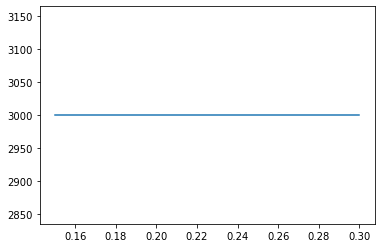

In [4]:
plt.plot(delays, res)

In [5]:
delays[res.argmin()]

0.15

In [6]:
np.abs((delays - 0.214)).argmin()

21

In [7]:
res[21]

3000

In [8]:
res.min()

3000

In [9]:
res.argmin()

0